In [2]:
import requests
import geopandas as gpd
import os
import threading
import time

In [2]:
type_list = ['simple', 'full']
level_list = ['country', 'province', 'city', 'district']

for tl in type_list:
    for level in level_list:
        if not os.path.exists(f'./{tl}/{level}'):
            os.makedirs(f'./{tl}/{level}')

In [3]:
def recur_fetch(adcode, threads):
    simple_file = f'{adcode}.json'
    full_file = f'{adcode}_full.json'
    prefix = 'https://geo.datav.aliyun.com/areas/bound/'

    # 对于出现异常的直接跳过
    try:
        # 先获取simple版的
        gdf = gpd.read_file(prefix+simple_file)
        level = gdf.level[0]
        # 在Windows环境下，没有encoding参数会报错
        gdf.to_file(f'./simple/{level}/{simple_file}', driver='GeoJSON', encoding='UTF-8')

        # 未必有full版的
        try:
            gdf = gpd.read_file(prefix+full_file)
            for index in gdf.index:
                sub_adcode = str(gdf.loc[index].adcode)
                # 避免父区域也包含在子区域中，造成无限循环
                if  sub_adcode != adcode:
                    t = threading.Thread(target=recur_fetch, args=(sub_adcode,threads, ))
                    t.start()
                    threads.append(t)
            gdf.to_file(f'./full/{level}/{full_file}', driver='GeoJSON', encoding='UTF-8')
        except:
            pass
    except:
        pass

In [4]:
adcode = '100000'

start = time.time()    
threads = []            
t = threading.Thread(target=recur_fetch, args=(adcode,threads,))
t.start()
threads.append(t)
for proc in threads:
    proc.join()
end = time.time()
print(f'Elapsed time:{end-start}')


C:\Users\v-xizhang1\scoop\apps\anaconda3\current\App\Lib\site-packages\geopandas\io\file.py:612: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
C:\Users\v-xizhang1\scoop\apps\anaconda3\current\App\Lib\site-packages\geopandas\io\file.py:612: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
C:\Users\v-xizhang1\scoop\apps\anaconda3\current\App\Lib\site-packages\geopandas\io\file.py:612: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
C:\Users\v-xizhang1\scoop\apps\anaconda3\current\App\Lib\site-packages\geopandas\io\file.py:612: UserWarning: You are attempting to write an empty DataFrame to file. For

Elapsed time:1228.2033867835999


POINT (96.25511723789646 39.7523833189472)
在甘肃省


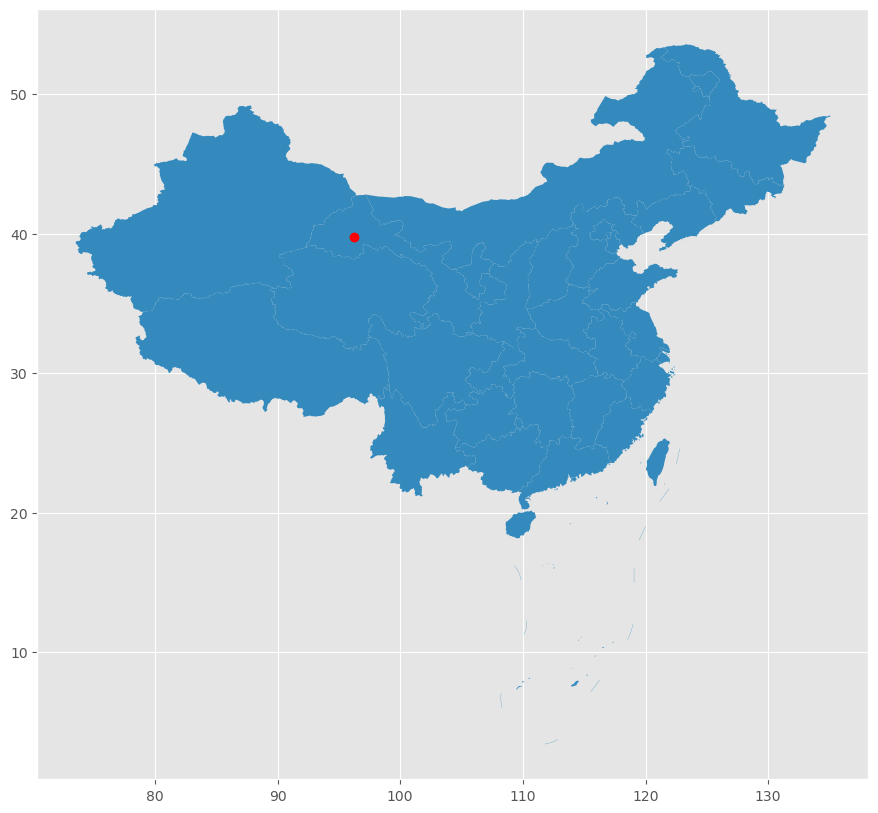

In [59]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import random

block_list = ["安徽省", "云南省", "西藏自治区", "北京市", "台湾省"]

geo_file_path = './full/country/100000_full.json'

# 加载中国和省份边界的GeoJSON文件
china_boundary_gpd = gpd.read_file(geo_file_path, encoding='UTF-8')
china_boundary = china_boundary_gpd.geometry.unary_union

def get_point_province(point):
    for province_data in china_boundary_gpd.itertuples():
        if province_data.geometry.contains(point):
            return province_data.name

def is_in_province(point, province_name):
    where = get_point_province(point)
    return where == province_name

def is_in_country(point):
    return china_boundary_gpd.geometry.unary_union.contains(point)

def generate_random_point_within_country():
    minx, miny, maxx, maxy = china_boundary.bounds
    while True:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if is_in_country(pnt):
            return pnt
        
def is_in_block_list(point, block_list):
    for block in block_list:
        if is_in_province(point, block):
            return False
    return True

while True:
    random_point = generate_random_point_within_country()
    if is_in_block_list(random_point, block_list):
        print(random_point)
        break
    
mpl.rcParams['figure.figsize']=(14,10)
plt.style.use('ggplot')
china_boundary_gpd.plot()
print("在"+get_point_province(random_point))
plt.plot(random_point.x, random_point.y, 'ro')
plt.show()